<h1> Evaluation (Graded Assignment) *Solution* </h1>
Now that you have been introduced to different methods of plotting, processing and loading the raw data data. Please complete this evaluation on extending the 1D beamforming and 1D Matched Filter into 2D processing. We have provided data where we have taken wireless images of various objects and your goal is to figure out what we have imaged. Different students will be assigned different sets of data, which will be determiend at the time of evaluation. At the bottom of the notebook are a few questions to answer.

Your deliverables are:
1. Add the implementation of 2D beamforming
2. Add the implementation of 2D matched filter algorithm
3. Answer the 3 questions at the bottom of the notebook

(HINT: Use as a skeleton the code from exercise_2.ipynb)

In [2]:

import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
import scipy.io as sio
import time

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [226]:
# TODO: Put the *path* to the project folder
home_dir = r"/Users/shanbhag/Documents/School/comm-proj-radars"

# loading data that is given
filename = r"data_001"
data_dir = r"given_data"
mat_data = sio.loadmat(os.path.join(home_dir,data_dir,filename + '.mat'))
raw_data = mat_data['adcData']
num_x_stp, num_z_stp, num_tx, num_rx, adc_samples = raw_data.shape

In [227]:
# define the antenna spacing

lm = 3e8/77e9 # define lambda for the antenna spacing
stp_size = 300*lm/4/369 # step size in the z (vertical) direction
rx_pos = np.reshape(np.arange(1,5,dtype=float),(-1,1)) * -lm / 2 # receiver positions 
x_pos = (np.reshape(np.arange(0,80,dtype=float),(-1,1)) * lm).T # x (horizontal) positions of the radar
x_ant_pos = np.reshape(np.squeeze(np.array([rx_pos + x_pos[0,i] for i in range(x_pos.shape[1])])),(-1,1)) # complete position of every receiver antenna

# make it 0 indexed
rx_pos = rx_pos - rx_pos[0] 
x_pos = x_pos - x_pos[0,0]
x_ant_pos = x_ant_pos - x_ant_pos[0]

# z (vertical) positions defined
z_pos = (np.reshape(np.arange(1,num_z_stp+1,dtype=float),(-1,1)) * stp_size).T
z_pos = z_pos - z_pos[0,0]


In [228]:
# reshape raw data and process beat frequency
X = raw_data
X = np.reshape(np.transpose(np.squeeze(X),(0,2,1,3)),(num_x_stp * num_rx, num_z_stp, adc_samples)) 
beat_freq = np.squeeze(scipy.fft.fft(X, axis=-1))
beat_freq = np.reshape(beat_freq,(-1,adc_samples))
X = np.reshape(X,(-1,adc_samples))

<h5> 1. Beamforming </h5>

In [257]:
################# Change the values based on how much of the azimuth angles you want to see and the resolution ##################
# Define field of view in degrees that you want to process in theta 
def beamform_2d(beat_freq_data, theta_s, theta_e, theta_res, phi_s, phi_e, phi_res, x_idx, z_idx):
    """
    Performs 2D beamforming along the azimuth (horizontal) dimension, this results in a bird eye view image.

    Paramters:
    - beat_freq_data: beat data AKA the range FFT (size: num TX * num RX * horizontal steps * vertical steps, num ADC samples)
    - theta_s: first azimuth angle that you want to start computing 
    - theta_e: last azimuth angle that you want to compute 
    - theta_res: resolution of the azimuth angles you want to compute
    - phi_s: first elevation angle that you want to start computing 
    - phi_e: last elevation angle that you want to compute 
    - phi_res: resolution of the elevation angles you want to compute
    - x_idx: x index of antenna locations
    - z_idx: z index of antenna locations

    Returns:
    - sph_pwr: beamformed result
    """
    idxs = np.arange(100,140,1) 
    adc_samples = len(idxs)
    # Convert everything to Radians 
    theta_s_r = theta_s * (np.pi/180)
    theta_e_r = theta_e * (np.pi/180)
    theta_res*= (np.pi/180)
    theta_rad_lim = [theta_s_r,theta_e_r]
    phi_s_r = phi_s * (np.pi/180)
    phi_e_r = phi_e * (np.pi/180)
    phi_res *= (np.pi/180)
    phi_rad_lim = [phi_s_r,phi_e_r]

    # Generate arrays for theta 
    theta = np.arange(theta_rad_lim[0], theta_rad_lim[1], theta_res)
    phi = np.arange(phi_rad_lim[0], phi_rad_lim[1], phi_res)
    N_theta = len(theta)
    N_phi = len(phi)

    # Initialize arrays for spherical power
    sph_pwr = np.zeros((N_theta, N_phi, adc_samples), dtype=complex)

    print("Running this many iterations: %d " % (N_theta*N_phi))
    i = 0
    ######################## BF Calculations ###########################
    for kt in range(N_theta):
        for kp in range(N_phi):
            start_time = time.time()
            cos_theta = np.cos(theta[kt])
            sin_theta = np.sin(theta[kt])
            cos_phi = np.cos(phi[kp])
            sin_phi = np.sin(phi[kp])
    
            cost_sinp = cos_theta * sin_phi
            sint_cosp = sin_theta * cos_phi

            Vec = np.exp(-1j*(2*np.pi*(z_idx*cost_sinp+ x_idx*sint_cosp)/lm)) # this is right for sure
            VecRFI = np.reshape(np.repeat(Vec[:, :, np.newaxis], len(idxs), axis=2),(-1,len(idxs)))
            sph_pwr[kt, kp, :] = np.squeeze(np.sum(np.multiply(beat_freq_data[:, idxs], (VecRFI)), axis=(0)))
            print("Processed angle (%.2f,%.2f) and took %.2f sec, %d/%d" % (theta[kt]*180/np.pi,phi[kp]*180/np.pi, abs(start_time - time.time()), i, N_theta*N_phi), end='\r')
            i += 1
    return sph_pwr

In [258]:
# define the azimuth angles (horizontal FOV) that we want to look at 
theta_s, theta_e = 75, 110
theta_res = 1.
phi_s, phi_e = 80, 120
phi_res = 1.
bf_output1 = beamform_2d(beat_freq, theta_s,theta_e,theta_res,phi_s,phi_e,phi_res,x_ant_pos,z_pos)

Running this many iterations: 1400 


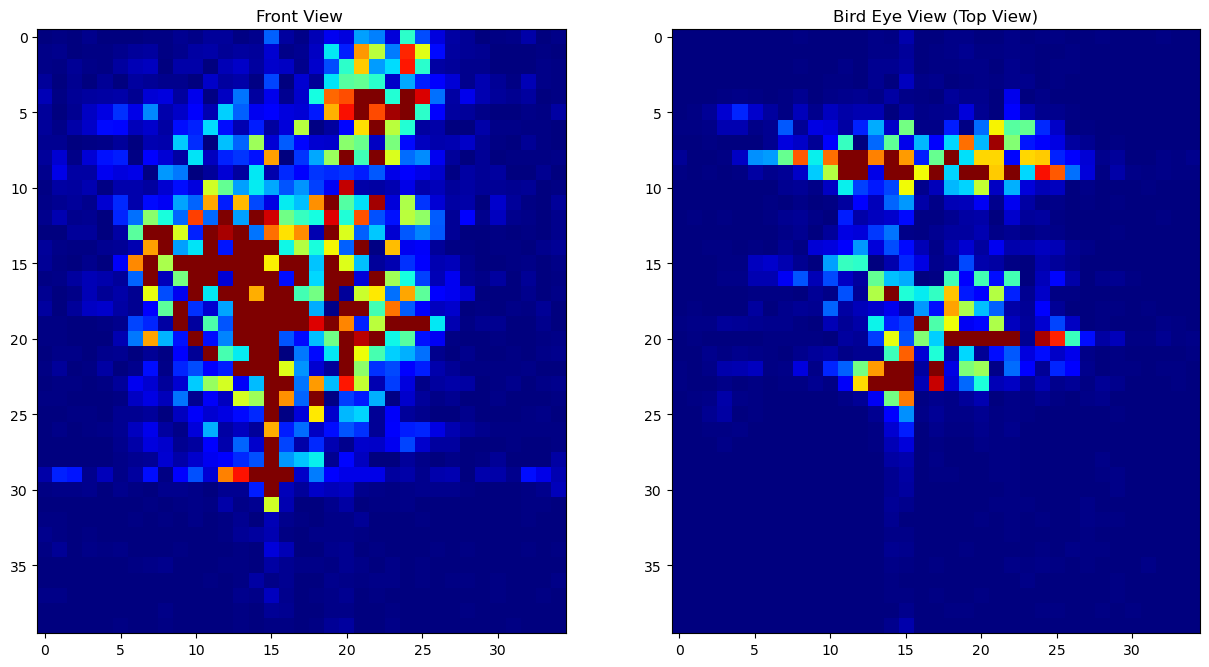

In [260]:
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(15, 15))

to_plot = np.sum(bf_output1,axis=-1)
to_plot = to_plot/np.max(np.reshape(to_plot,(1,-1))) 
to_plot = to_plot[:,::-1]**2
ax0.imshow(abs((to_plot).T), cmap = 'jet',  vmin=0, vmax=0.1) # this is giving the y axis in meters, and x axis in angles 
ax0.title.set_text('Front View ')
to_plot = np.sum(bf_output1,axis=1)
to_plot = to_plot/np.max(np.reshape(to_plot,(1,-1))) 
to_plot = to_plot[:,::-1]**2
ax1.imshow(abs((to_plot).T), cmap = 'jet',  vmin=0, vmax=0.2) # this is giving the y axis in meters, and x axis in angles 
ax1.title.set_text('Bird Eye View (Top View)')

<h5> 2. Matched Filter </h5>

In [217]:
######## 1D Imaging in Cartesian #############
def matched_filter_2d(raw_data_2d, num_x_cells, num_z_cells, x_radar_tx, x_radar_rx, z_radar_tx, z_radar_rx, cell_y):
    """
    Computes the 1D matched filter result for raw data, this is done along the X, Y dimensions (results in a birds eye view image).

    Paramters:
    - raw_data_2d: raw ADC data (size: num Tx * num Rx * horizontal steps * vertical steps, num ADC samples)
    - num_x_cells: discrete locations in X (horizontal) that you want to compute the power of
    - num_z_cells: discrete locations in Z (vertical) that you want to compute the power of
    - x_radar_tx: horizontal positions of the transmitters 
    - x_radar_rx: horizontal positions of the receivers 
    - z_radar_tx: vertical positions of the transmitters  
    - z_radar_rx: vertical positions of the receivers 
    - cell_y: depth slice we want to calculate

    Returns:
    - MF_output: matched filter output
    """
    c = 2.9979
    fc_start =  773.704
    chirpSlope = 70.295e12
    adcSampleRate = 10e6
    As_sci = (chirpSlope/1e8)

    # to speed up processing just look at this subset of samples
    adc_sampless = np.arange(100,140)
    X_ = raw_data_2d[:,adc_sampless]
    adc_samples_mf = X_.shape[1]

    MF_output = np.zeros((len(num_x_cells),len(num_z_cells)),dtype=complex)
    index = 0
    for i,cell_x in enumerate(num_x_cells):
        for j,cell_z in enumerate(num_z_cells):
                start_time = time.time()

                # round trip distance of signal to (cell_x, cell_y, cell_z)
                cell_dist = np.sqrt((x_radar_tx - cell_x)**2 + (cell_y)**2 + (z_radar_tx - cell_z)**2) + np.sqrt((cell_x - x_radar_rx)**2 + (cell_y)**2 + (z_radar_rx - cell_z)**2) # size is (num_z_stp,1)

                cell_dist = np.reshape(cell_dist,(-1,1)) + 0.15 # account for range bias
                temp_tau = (cell_dist)/c
                
                temp_sig_phase = 2.0*np.pi*fc_start*temp_tau
                total_phase = np.repeat(temp_sig_phase,adc_samples_mf,axis=1) + 2.0 * np.pi * As_sci * (adc_sampless.T / adcSampleRate) * temp_tau
                temp_real = np.cos(total_phase)
                temp_imag = -np.sin(total_phase)
                MF_output[i,j] = MF_output[i,j] + np.sum((X_ *  (temp_real + temp_imag*1j)),axis=(0,1))
                            
                print("Processed cell (%.2f,%.2f,%.2f), which is (%d/ %d) and took %.2f sec)    " % (cell_x,cell_y,cell_z,index,len(num_x_cells)*len(num_z_cells),abs(start_time - time.time())), end='\r')
                index += 1
    return MF_output 

In [219]:
num_x_cells = np.arange(-0.15,0.53,0.025)
num_z_cells = np.arange(-0.44,0.2,0.025)
cell_y = 4.3 

# transmitters x position is one every lambda (repeat by four to match size of x_radar_rx) and shift by the physical offset on the board
x_radar_tx = np.reshape(np.repeat(x_pos,4),(-1,1)) - 0.005 - 3 * lm / 2 
x_radar_rx = x_ant_pos 
z_radar_tx = z_pos
z_radar_rx = z_pos 

MF_output = matched_filter_2d(X, num_x_cells, num_z_cells, x_radar_tx, x_radar_rx, z_radar_tx, z_radar_rx, cell_y)

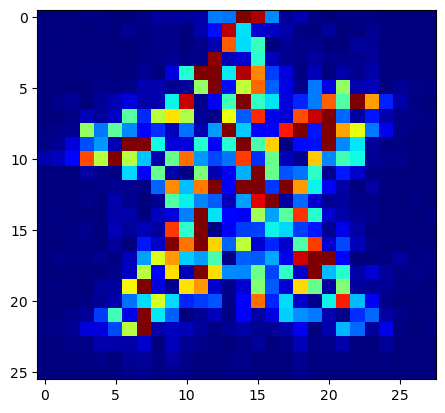

In [220]:
to_plot = MF_output
to_plot = to_plot/np.max(np.reshape(to_plot,(1,-1)))
to_plot = to_plot[:,::-1]**2 # reverse direction so that we are right side up
plt.imshow(abs((to_plot).T), cmap = 'jet',  vmin=0, vmax=0.3) 

<h5> Question 1: Look through the possible objects that have been imaged, and match your output to one of these objects. Write the object below: </h5>

Depends on your data.

<h5>Question 2: Which image looks more realistic, beamforming or matched filter?  </h5>

Matched Filter.

<h5> Question 3: Explain the reason for one processing algorithm to produce better images than the other. </h5>

Beamforming makes an assumption on the incoming signal. Essentially it assumes that our reflector is far enough away that the incoming rays to each antenna are parallel to each other. You can only make this assumption when the distance from the antenna array to the reflectors are much greater than the wavelength/spacing of the antennas. This assumption means that we are assuming the transmitter and receiver antennas are at the same location *and* that the adjacent antennas are seeing parallel rays. This is not going to be the most accurate in estimating the extra distance traveled by the signal, and this is why the output seen by the beamforming algorithm is not very good looking, especially for the data given, as they are in the *nearfield* (aka our parallel ray assumption fails). 

Matched filter, on the other hand, calculates the exact signal we expect to receive and does not make an assumption on the incoming signal. In other words, it calculates the round trip distance from each transmitter to a voxel in space and then back to the receiver, accounting for each of their exact locations. It simulates the expected signal, and then it correlates this expected signal with what we received, and if they match (hense matched filter) then we will see a peak (in terms of heatmap this means a stronger power). However, this is computationally expensive as it requires calculating this for every singal voxel in space. 